<a href="https://colab.research.google.com/github/pranav-kural/deep-learning-textual-analysis/blob/main/Deep_Learning_Textual_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Applied to Textual Data

In this notebook we will perform a classification empirical study using real textual data.

This is part of **Assignment 4** of the course CSI4106 at University of Ottawa.

Author: Pranav Kural

Group: 28 | Student number: 300241227

In [1]:
# dependencies
import numpy as np
import pandas as pd
import spacy
from joblib import dump, load

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
# set SNS theme
sns.set_theme(style="darkgrid", palette="Paired")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import clone as clone_model

## Data

Let's begin by having a closer look and preparing our data.

Dataset selected: **Airline Passenger Reviews** <sup>[1](#1-airline-passenger-reviews-dataset)</sup>

Reason for selection:

- Enough training data is available and the class imabalance is not too bad.

- Did not choose the **4000 CNN articles dataset** because of the presence of too many classes, and the difficulty of effectively classifying articles when there is an overlap, for example, an article about US and politics has to be categorized into only one of the categories, even though it may relate to both equally. Also, less training data is available in comparison to other datasets.

- Did not choose the **UCI Drug Review dataset** because the substantial class imabalance in the dataset. One dominant condition "birth control" accounts for more than all other conditions combined (based on original dataset).

### 1. Generate two additional datasets

We will generate two additional datasets from our selected original dataset, so that we have three datasets to work with at the end:

- Original Dataset
- Derived-Dataset-1: contains subset of POS tags (Part-of-Speech tags)
- Derived-Dataset-2: contains subset of named entities found in the text + some POS of importance

For example:

- Original Dataset
- Derived-Dataset-1 with only the verbs and adjectives lemmatized
- Derived-Dataset-2 with 3 types of named entities (organizations, money and dates) and with adjectives lemmatized

In our classification experiments, we will test with these 3 datasets and compare results.

### Original Dataset

We will be using a reduced version of the original dataset for this study. The dataset being used is openly available at: https://github.com/pranav-kural/deep-learning-textual-analysis/blob/main/reduced_file_AirPassengerReviews.csv



In [2]:
# dataset location
ds_url = 'https://raw.githubusercontent.com/pranav-kural/deep-learning-textual-analysis/main/reduced_file_AirPassengerReviews.csv'

# load original dataset
original_ds = pd.read_csv(ds_url)

# display a short description
original_ds.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor


#### Understanding the data

Let's do a basic statistical analysis of our data to know what we are going to be working with.

In [3]:
# display statistical summary
print(original_ds.describe())

                                          customer_review  NPS Score
count                                               10761      10761
unique                                              10661          3
top     I took a flight from Boston to Munich. As it i...  Detractor
freq                                                    2       4891


So, we have three unique values for the target class **NPS Score**.

In [4]:
original_ds['NPS Score'].unique()

array(['Passive', 'Detractor', 'Promoter'], dtype=object)

Let's study the class distribution to be better aware of any class imabalance.

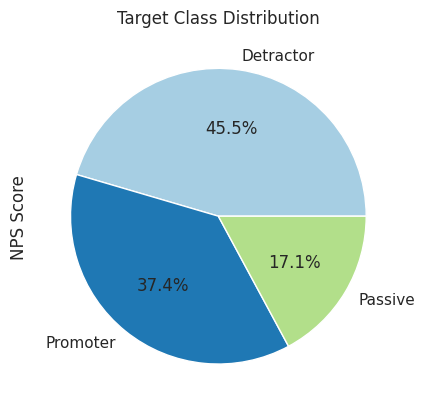

In [5]:
# plot a pie chart to display class distribution
original_ds['NPS Score'].value_counts().plot(kind="pie",autopct="%.1f%%",title='Target Class Distribution')
plt.show()

We can observe from the above that there is a slight class imbalance where we have a very small proportion of reviews belonging to the `Passive` category.

To handle this class imbalance, we can undertake a few approaches:

1. Drop some of the reviews belonging to the two dominant classes, so the class distribution is more uniform. **Drawback:** will loose some of the training data

2. Add more reviews belonging to the `Passive` category, either generated by humans or using a LLM.


#### Balanced Original Dataset

To keep things simple, we will use the second approach mentioned in the previous section to cater to the class imbalance in our original dataset. To later assess the impact of handling this class imbalance on the performance of our models, we will create a separate new dataset which will have a more uniform distribution of target class.

Detractor    2445
Promoter     2013
Passive      1843
Name: NPS Score, dtype: int64


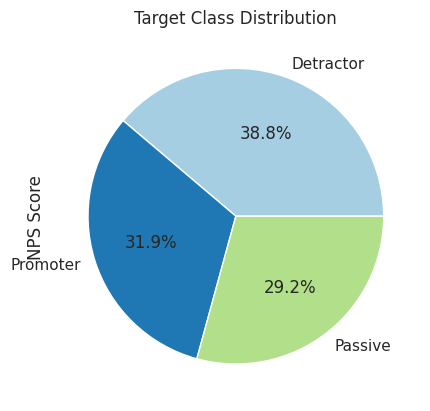

In [6]:
# drop first half of the rows belonging to the class Detractor
detractor = original_ds[original_ds['NPS Score'] == 'Detractor']
detractor = detractor.drop(detractor.index[len(detractor)//2:])

# drop first half of the rows belonging to the class Promoter
promoter = original_ds[original_ds['NPS Score'] == 'Promoter']
promoter = promoter.drop(promoter.index[len(promoter)//2:])

# get all rows belonging to the class Passive
passive = original_ds[original_ds['NPS Score'] == 'Passive']

# create a new dataset with a more balanced distribution of each target class
original_ds_balanced = pd.concat([detractor, promoter, passive])

# shuffle the rows of the new dataset after combining target class datasets
original_ds_balanced.sample(frac=1)

# display the number of rows belonging to each class
print(original_ds_balanced['NPS Score'].value_counts())

# plot a pie chart to display class distribution
original_ds_balanced['NPS Score'].value_counts().plot(kind="pie",autopct="%.1f%%",title='Target Class Distribution')
plt.show()

As you can observe from above, we now have a much more balanced dataset, though the total number of training examples has reduced now.

In [7]:
print("Original Dataset row count: ", original_ds.count()[0])
print("Original Balanced Dataset row count: ", original_ds_balanced.count()[0])

Original Dataset row count:  10761
Original Balanced Dataset row count:  6301


Going forward, we will use a flag to ascertain whether we want to use balanced dataset (with less training examples) or the original dataset.

In [8]:
# flag to specify if balanced dataset is to be used
use_balanced_dataset = True

# ds will be the datset used from now for original data
ds = original_ds

# if using balanced data, set ds to balanced dataset
if use_balanced_dataset:
  ds = original_ds_balanced

### NLP Pipeline

Before we can derive our two additonal datasets, we need to define our NLP pipeline using [spaCy](https://spacy.io/).

We are going to load the [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) English pipeline provided by spaCy since its well optimized for CPU processing.

In [9]:
# load the NLP pipeline
nlp = spacy.load("en_core_web_sm")

Applying the pipeline to every sentence creates a Document where every word is a Token object.

Doc: https://spacy.io/api/doc

Token: https://spacy.io/api/token

In [10]:
# specify column name to store tokens of reviews
ds_tokens_col = 'tokenized'

# apply NLP pipeline to the column that has sentences
ds[ds_tokens_col] = ds['customer_review'].apply(nlp)

# display top 5 rows to view the results of NLP piepline processing
ds.head(5)

,customer_review,NPS Score,tokenized
1,Istanbul to Bucharest. We make our check in i...,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."
5,Istanbul to Budapest via Dublin with Turkish ...,Detractor,"( , Istanbul, to, Budapest, via, Dublin, with,..."
6,"Istanbul to Algiers, planned to take off at 9...",Detractor,"( , Istanbul, to, Algiers, ,, planned, to, tak..."


#### Utility methods

Before we continue with processing the tokens, let's define two utility methods that we will be using later to derive additional datasets.

In [11]:
# method to extract wanted POS from the given sentences containing tokens
def get_pos(sentence, wanted_pos):
    pos = []
    for token in sentence:
        if token.pos_ in wanted_pos:
            # add the lemmatized text of the token to result
            pos.append(token.lemma_) # lemma returns a number. lemma_ return a string
    return ' '.join(pos) # return value is as a string and not a list for countVectorizer

# method to extract wanted Named Entities (NE) & POS tags from given sentences containing tokens
def get_ne_and_pos(sentence, wanted_ne, wanted_pos):
    ne = []
    for token in sentence:
        # if current token belongs to one of the wanted Named Entities & POS
        if (token.ent_type_ in wanted_ne) or (token.pos_ in wanted_pos):
            # add the lemmatized text of the token to result
            ne.append(token.lemma_) # lemma returns a number. lemma_ return a string
    return ' '.join(ne) # return value is as a string and not a list for countVectorizer

### Derived Dataset 1

For generating our first derived dataset, we will focus on following POS: 'ADJ', 'ADV', 'NOUN', 'INTJ'

**Reasoning**

In terms of review analysis, the most important part-of-speech tags are adjectives, adverbs and nouns. Adjectives and adverbs are used to describe the sentiment of the text, while nouns are used to identify the subject or object of the text. <sup>[2](#2-word-classes-and-part-of-speech-tagging-in-nlp)</sup>

We will also include interjections in wanted POS tags, since they typically express an emotional reaction. <sup>[3](#-3-interjections-universal-dependencies)</sup>

List of POS tags available here: https://universaldependencies.org/u/pos/

In [12]:
# generate derived-ds-1

# wanted POS
wanted_pos = ['ADJ', 'ADV', 'NOUN', 'INTJ']

# declare derived dataset (empty for now)
derived_ds_1_tokens_col = 'pos'
derived_ds_1_class_col = 'class'
derived_ds_1 = pd.DataFrame(columns = [derived_ds_1_class_col, derived_ds_1_tokens_col])

# add the wanted POS for each sentence to the POS column for each row
derived_ds_1[derived_ds_1_tokens_col] = ds[ds_tokens_col].apply(lambda sent : get_pos(sent, wanted_pos))
# add the target class column
derived_ds_1[derived_ds_1_class_col] = ds['NPS Score']

# verify the number of rows
print("Original Dataset row count: ", ds.count()[0])
print("Derived Dataset 1 row count: ", derived_ds_1.count()[0])

# display first few rows
derived_ds_1.head(5)

Original Dataset row count:  6301
Derived Dataset 1 row count:  6301


,class,pos
1,Detractor,check airport luggage gate gate surprise board...
2,Detractor,company several time past year honestly bad ba...
4,Detractor,never book turkish airline flight delay other ...
5,Detractor,delay flight leg journey stuck almost hour gro...
6,Detractor,pm pm same night announcement flight hour tech...


### Derived Dataset 2

For generating our first derived dataset, we will focus on following named entities and POS.

Wanted NE: `'GPE', 'PERSON', 'ORG', 'DATE', 'TIME', 'MONEY', 'ORDINAL', 'PRODUCT', 'LANGUAGE', 'EVENT'`

Wanted POS: `'ADJ', 'ADV', 'NOUN', 'PRON', 'INTJ'`

**Reasoning**

GPE (Geopolitical entities): Certain cities, countries may be more likely to have a certain type of service quality or may tend to a majority of customers belonging to a certain category, for example London might have bad service and most customers going through London might have a higher tendency to give negative reviews.

PERSON, ORG: Mentioning people or organization by name may indicate reviewer expressing certain personal emotion.

DATE, TIME: Values such as "three hours late" may indicate a negative feedback, so are important to consider.

MONEY, ORDINAL: Its not common to mention monetary or ordinal values (like first, second, so on.) in passive reviews, so the inclusion of such values may indicate certain sentimental feedback.

PRODUCT: Can be used to identify certain product (like food) that the customer maybe satisfied or disatisfied with.

LANGUAGE: Its not common for customers to mention language in review, so it may indicate to strongly positive or negative experience.

EVENT: Customer may mention specific events in their review to explain certain special experiences they might have experienced whether positive or negative.



In [13]:
# generate derived-ds-2

# wanted POS & Named Entities
wanted_pos = ['ADJ', 'ADV', 'NOUN', 'INTJ']
wanted_ne = ['GPE', 'PERSON', 'ORG', 'DATE', 'TIME', 'MONEY', 'ORDINAL', 'PRODUCT', 'LANGUAGE', 'EVENT']

print("Verify the implementation of our named entity extraction. Using first review in dataset as example.")
print("\nOriginal Text (first 20 characters): ", ds[ds_tokens_col][0][:20])
print("After extraction of wanted named entities (from complete review text): ", get_ne_and_pos(ds[ds_tokens_col][0], wanted_ne, wanted_pos)[:50])

# declare derived dataset (empty for now)
derived_ds_2_tokens_col = 'ne_and_pos'
derived_ds_2_class_col = 'class'
derived_ds_2 = pd.DataFrame(columns = [derived_ds_2_class_col, derived_ds_2_tokens_col])

# add the wanted Named Entities & POS tags for each sentence to the NE column for each row
derived_ds_2[derived_ds_2_tokens_col] = ds[ds_tokens_col].apply(lambda sent : get_ne_and_pos(sent, wanted_ne, wanted_pos))
# add the target class column
derived_ds_2[derived_ds_2_class_col] = ds['NPS Score']

# verify the number of rows
print("\nOriginal Dataset row count: ", ds.count()[0])
print("Derived Dataset 2 row count: ", derived_ds_2.count()[0], "\n")

# display first few rows
derived_ds_2.head(5)

Verify the implementation of our named entity extraction. Using first review in dataset as example.

Original Text (first 20 characters):   London to Izmir via Istanbul. First time I'd flown TK. I found them very good in
After extraction of wanted named entities (from complete review text):  London Izmir Istanbul first time very good air cab

Original Dataset row count:  6301
Derived Dataset 2 row count:  6301 



,class,ne_and_pos
1,Detractor,Istanbul check airport luggage gate gate surpr...
2,Detractor,Rome Prishtina Istanbul company several time t...
4,Detractor,Mumbai Dublin Istanbul never book turkish airl...
5,Detractor,Istanbul Budapest Dublin Turkish Airlines dela...
6,Detractor,Istanbul Algiers 9:30 pm Algiers 11:20 pm same...


This concludes the derivation of two additional datasets. Now we have three datasets to work with:

- `ds`: original dataset (balanced or imbalanced)
- `derived_ds_1`: derived dataset 1 (containing wanted POS tags)
- `derived_ds_2`: derived dataset 2 (containing wanted named entities and POS tags)



---



## Classification Empirical Study


### 1. Encode text as input features with associated values

Using `scikit-learn` we encode the text data as features which can than be used in our deep learning model. The text becomes a [bag-of-words](#) where each word becomes an independent feature.

We will also remove [stopwords](#) to reduce the corpus size and use tf-idf as attribute value.

**Why use TF-IDF?**

Using relative frequency of a word in the corpus allows for better identification of more important and meaningful words relative to the documents, instead of simply assigning the importance of a word based on its frequency in the corpus. For example, a word occuring more often in only two of the six documents would likely be more important and meaningful to those two documents, compared to a word that occurs more frequently in all the six documents. <sup>[4](#-4-tf-idf-and-simple-document-search)</sup>

<img src="https://drive.google.com/uc?id=1qiq4wWu4078sHKhDdeW6-5YgM-qwnbmy" alt="TF-IDF" width=400 />
<p id="img-source">source: <a href="https://youtu.be/fIYSi41f1yg?si=-oFATPFxyop7RnmE">NLP Demystified 6: TF-IDF and Simple Document Search</a></p>

#### TfidfVectorizer

We will use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) provided by `scikit-learn`, which builds a dictionary of features and transforms documents to feature vectors.

In [14]:
# TfidfVectorizer - use TF-IDF and remove english stopwords
tfvectorizer = TfidfVectorizer(use_idf=True, stop_words='english')

# encode text as input features with associated values - generate bag-of-words
X_ds = tfvectorizer.fit_transform([token.text for token in ds[ds_tokens_col]])
X_derived_ds_1 = tfvectorizer.fit_transform(derived_ds_1[derived_ds_1_tokens_col])
X_derived_ds_2 = tfvectorizer.fit_transform(derived_ds_2[derived_ds_2_tokens_col])

# target column dataset
Y_ds = ds['NPS Score']

print("X_ds_train count: ", X_ds.shape[0])
print("X_derived_ds_1_train count: ", X_derived_ds_1.shape[0])
print("X_derived_ds_2_train count: ", X_derived_ds_2.shape[0])
print("Y_ds count: ", Y_ds.shape[0])

X_ds_train count:  6301
X_derived_ds_1_train count:  6301
X_derived_ds_2_train count:  6301
Y_ds count:  6301


These features vector stores will be used in our model training, testing and evaluation.

### 2. Two models using default parameters

We will define two models using default parameters: one supervised learning model ([Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) and one deep learning model ([MLP classifier model](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)).

In [15]:
# Logistic Regression with default parameters
lg = LogisticRegression()

# MLP Classifier with default parameters
mlp_1 = MLPClassifier()

### 3. Train Test Evaluate

Now, we will train, test and evaluate previously defined two models (using default parameters) on the three datasets (original dataset, derived-dataset-1 and derived-dataset-2).

#### 1. Train

For training the model, let's define our cross validation instance to be used across all models. We will also create a method to help train the model and return the results based on scoring metrics specified.

We will be using [4-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) for each of the models, and assess each model's performance based on precision and recall using both micro and macro averaging.


In [16]:
# default cross validation using 4-fold splits
skf = StratifiedKFold(n_splits=4)
# scoring metrics to use for cross validation
scoring=['precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']
# set n_jobs to -1 to use multi-processing cores
n_jobs = -1

Let's define some utility methods to train models and obtain required scores.

In [17]:
# method to use the 'cross_validate' function from scikit-learn to train and evaluate the model
# returns a pandas dataframe containing results of scoring metrics
def train_model(mod, X, y, cv, scoring, n_jobs):
    # create a copy of the model
    # this prevents the same instance of model being re-trained if called twice
    estimator = clone_model(mod)
    scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
    sp = pd.DataFrame()
    sp["p_macro"] = scores["test_precision_macro"]
    sp["p_micro"] = scores["test_precision_micro"]
    sp["r_macro"] = scores["test_recall_macro"]
    sp["r_micro"] = scores["test_recall_micro"]
    return sp

# method to train and get scores
def train_and_score_model(mod):
  scores = []

  # train models on each of the datasets
  datasets = [X_ds, X_derived_ds_1, X_derived_ds_2]

  # train models and append scores
  for X in datasets:
    scores.append(train_model(mod, X, Y_ds, skf, scoring, n_jobs))

  # return the scores
  return scores

# method to return mean scores for each of the datasets give the cross validation scores
def return_mean_scores(scores):
  results=[]
  results.append(scores[0].mean().to_numpy()) # original dataset scores at index 0
  results.append(scores[1].mean().to_numpy()) # derived 1 dataset scores at index 1
  results.append(scores[2].mean().to_numpy()) # derived 2 dataset scores at index 2
  results = pd.DataFrame(results)

  results.columns = scores[0].columns.to_numpy()
  results.index = ["Original Dataset", "Derived 1", "Derived 2"]
  return results

Now, let's use the above define utility methods to train our models created using default parameters and obtain their scores.

In [18]:
# train models and store the scores
lg_scores = train_and_score_model(lg)
mlp_1_scores = train_and_score_model(mlp_1)

# display mean scores
print("\nLogistic Regression (with default parameters) Scores: ")
print(return_mean_scores(lg_scores))
print("\nMLP Classifier (with default parameters) Scores: ")
print(return_mean_scores(mlp_1_scores))


Logistic Regression (with default parameters) Scores: 
                   p_macro   p_micro   r_macro   r_micro
Original Dataset  0.579376  0.599421  0.576800  0.599421
Derived 1         0.643936  0.667669  0.647802  0.667669
Derived 2         0.577579  0.595932  0.574841  0.595932

MLP Classifier (with default parameters) Scores: 
                   p_macro   p_micro   r_macro   r_micro
Original Dataset  0.568668  0.591482  0.571270  0.591482
Derived 1         0.592780  0.609104  0.594034  0.609104
Derived 2         0.559019  0.570690  0.553418  0.570690


#### 2. Evaluate

We will now evaluate the precision/recall measures of each of the models. Since, we are working with a multi-class classification problem, we will be comparing both micro and macro averages.

Before we can begin evaluation though, let's define some utility methods which will help in extraction of relevant metric scores and their visualization.

In [19]:
# method to extract and combine results of model training and evaluation
def get_results(ds_1_scores, ds_2_scores, label_1="lg", label_2="mlp", columns="", indices=""):
    # store results
    results = []
    # calculate and append mean scores
    results.append(ds_1_scores.mean().to_numpy())
    results.append(ds_2_scores.mean().to_numpy())
    # convert to data frame
    results = pd.DataFrame(results)
    # add columns and index values
    results.columns = columns
    results.index = indices
    # return results
    return results

# function to generate visual graphs for comparison of precision and recall
def compare_results(ds_1_scores, ds_2_scores, mod_1="", mod_2="", kind='bar', figsize=(6,4)):
  # labels to differentiate dataset type
  dataset_names = ["(X_ds)", "(X_derived_1)", "(X_derived_2)"]
  # names of respective datasets corresponding to labels above
  dataset_titles = ["Original Dataset", "Derived Dataset 1", "Derived Dataset 2"]
  # for each of the datasets
  for i in range(len(ds_1_scores)):
    # get column and indices names
    columns = ds_1_scores[i].columns
    indices = [f"{mod_1} {dataset_names[i]}", f"{mod_2} {dataset_names[i]}"]
    # get results from the model scores
    results = get_results(ds_1_scores[i], ds_2_scores[i], columns=columns, indices=indices)
    # plot a bar graph of the results
    results.plot(kind=kind, figsize=figsize, rot=0, title=dataset_titles[i])
    plt.show()

Now, let's visually examine the performance of our models on each of the datasets and compare their precision/recall micro and macro scores.

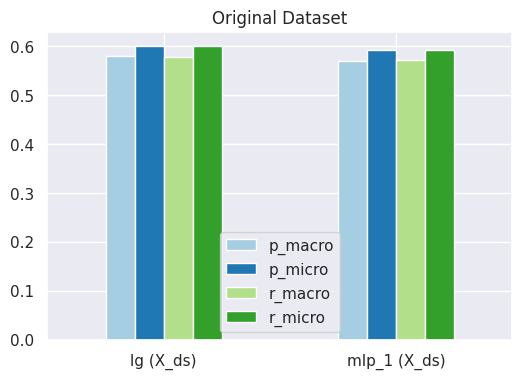

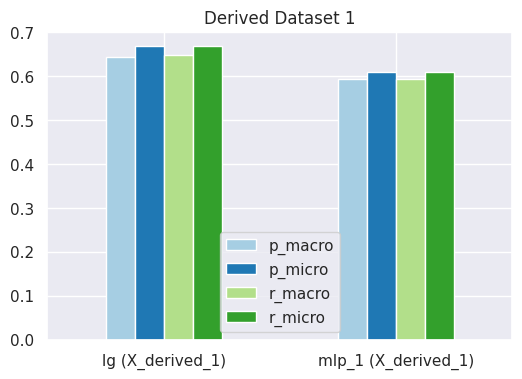

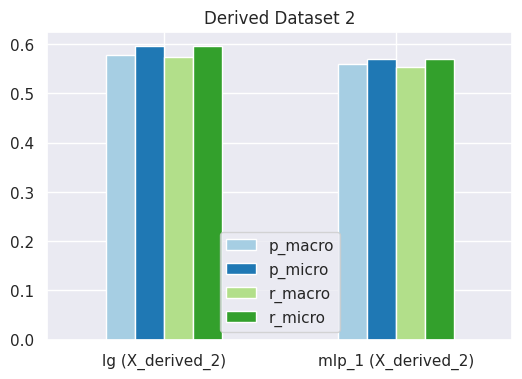

In [20]:
# compare precision and recall of our models on the three datasets
compare_results(lg_scores, mlp_1_scores, mod_1="lg", mod_2="mlp_1", kind="bar")

**Observations:**

Both our models instantiated with default parameters perform fairly similarly, although the logistic regression model seems to perform slightly better.

**How the class imbalance impacts the micro/macro results?**

If using the balanced dataset, we would notice only a small difference between the micro and macro averaging scores, since the target class is pretty uniformly distributed. However, if using the non-balanced (original) dataset, we would notice that scores for precision/recall based on macro averaging are generally lower than the micro averaging scores. We will discuss the reasons for this in detail later on.

## Improving our MLP classifier model

Now, that we have examined the performance of our models with default parameters, we will modify some parameters of our MLP classifier model, and train, test and evaluate its performance again, to see how changes in parameters affect the model performance.

We will do this **two times**.

### 1. Attempt 1 - MLP model #2

Parameters being changed:

`hidden_layer_size=(64,256,512,128,32)`

**Reasoning:**

Let's start by making a simple change in the number of hidden layers and the number of neurons in each of those hidden layers.

Please note that, the very empirical nature of working with deep learning models imply iterative experimentation to come on a consesus for relatively optimal values of a hyperparameter. As such, to find a "good" value for the number of hidden layers and the number of neurons, I had to perform experiments with different values, and then select the best performing.

Initial or default number of layers for MLPClassifier provided by scikit-learn is **100 neurons in 1 hidden layer (100,)**. <sup>[5](#5-mlp-classifier)</sup>

I gradually increased the number of layers and number of neurons in each layer until the model started to perform worse.

Here are some results from that experiment (only original dataset results shown here):
```
hidden_layer_sizes=(50,50)
  p_macro    0.549812
  p_micro    0.572604
  r_macro    0.551309
  r_micro    0.572604

hidden_layer_sizes=(32,64)
  p_macro    0.554416
  p_micro    0.574985
  r_macro    0.554325
  r_micro    0.574985

hidden_layer_sizes=(32,64,128,64,32)
  p_macro    0.607146
  p_micro    0.597363
  r_macro    0.585835
  r_micro    0.597363

hidden_layer_sizes=(64,256,512,128,32)
  p_macro    0.621539
  p_micro    0.601490
  r_macro    0.593158
  r_micro    0.601490

hidden_layer_sizes=(64,256,512,128,64)
  p_macro    0.562348
  p_micro    0.564830
  r_macro    0.548378
  r_micro    0.564830

```

It is clear from above, that after a certain point, increasing the number or size of hidden layers starts to deteriorate model performance.

In [21]:
# parameters
# 5 hidden layers of sizes given below
hidden_layer_sizes=(64,256,512,128,32)

# instantiate the new MLP model
mlp_2 = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)

# train the new model on all three datasets and store the scores
mlp_2_scores = train_and_score_model(mlp_2)

# display mean scores
print("\nMLP Classifier model #2 Scores: ")
print(return_mean_scores(mlp_2_scores))


MLP Classifier model #2 Scores: 
                   p_macro   p_micro   r_macro   r_micro
Original Dataset  0.618024  0.598785  0.591078  0.598785
Derived 1         0.624089  0.619103  0.609622  0.619103
Derived 2         0.614525  0.594661  0.587816  0.594661


### 2. Attempt 2 - MLP model #3

Parameters being changes:
```
hidden_layer_sizes=(32,64,128)
solver = 'sgd'
early_stopping = True
learning_rate_init = 0.01
learning_rate = 'adaptive'
```

**Reasoning:**

Similar to the approach taken in the previous attempt, several iterative experiments were performed with various different values of hyper-parameters to come to these parameters and values.

Logical reasoning for why some of these parameters might be performing better:

**SGD**: Stochastic Gradient Descent or SGD, generalizes better than adaptive optimizers like Adam or RMSProp, although it is comparatively slower. <sup>[6](#6-using-sgd-optimizer)</sup>

**Early Stopping**: Early stopping simply allows the training process to stop earlier if there is no significant improvement noticed in the validation accuracy after certain epochs.

**Learning Rate**: Using a slightly higher learning rate helps speed up the training process in the starting or model training. Combining it with **adaptive learning rate** ensures that our model doesn't overfit on training data too early or that it gets stuck in a local maxima.

In [22]:
# parameters
hidden_layer_sizes=(32,64,128)
solver = 'sgd'
early_stopping = True
learning_rate_init = 0.01
learning_rate = 'adaptive'


# instantiate the new MLP model
mlp_3 = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    solver=solver,
    early_stopping=early_stopping,
    learning_rate_init=learning_rate_init,
    learning_rate=learning_rate)

# train the new model on all three datasets and store the scores
mlp_3_scores = train_and_score_model(mlp_3)

# display mean scores
print("\nMLP Classifier model #3 Scores: ")
print(return_mean_scores(mlp_3_scores))


MLP Classifier model #3 Scores: 
                   p_macro   p_micro   r_macro   r_micro
Original Dataset  0.640886  0.633065  0.623728  0.633065
Derived 1         0.655973  0.670366  0.655453  0.670366
Derived 2         0.634407  0.632118  0.619935  0.632118


## Comparative Analysis

We will now quantitatively and visually compare the precision and recall measures of our 12 results. The 12 results come  from 4 models (Logistic Regression + 3 variations of MLP) each applied on 3 datasets (Original + Derived1 + Derived2).

However, before we can dive into the analysis, let's define some utility functions to help us compare and visualize data better.


In [23]:
# index values to access specific dataset results
org_ds_idx = 0
d1_ds_idx = 1
d2_ds_idx = 2

# method to return mean score of dataset given by ds index
# 0 -> Original Dataset, 1 -> Derived Dataset 1,  2 -> Derived Dataset 2
def get_dataset_mean_scores(ds_idx):
  # store results
  results = []
  # calculate and append mean scores for each model
  results.append(lg_scores[ds_idx].mean().to_numpy())
  results.append(mlp_1_scores[ds_idx].mean().to_numpy())
  results.append(mlp_2_scores[ds_idx].mean().to_numpy())
  results.append(mlp_3_scores[ds_idx].mean().to_numpy())
  # store in data frame
  results = pd.DataFrame(results)
  # update column and row names
  results.columns = lg_scores[ds_idx].columns
  results.index = ["lg", "mlp 1", "mlp 2", "mlp 3"]
  # return dataframe containing results
  return results

# method to plot graph given results containing mean scores of all models for a specific dataset
def plot_results_graph(results, kind="bar", figsize=(11,5), title=""):
  results.plot(kind=kind, figsize=figsize, rot=0, title=title)

# method to display lineplot for results
def results_lineplot(results, title=''):
  sns.relplot(data=results, kind="line", palette="tab10")
  plt.title(title)
  plt.show()

### Comparison 1 - Original Dataset

In this comparison, we will check how our 4 models performed on the **original dataset**.

In [24]:
# obtain results for Original Dataset
results = get_dataset_mean_scores(org_ds_idx)
results

,p_macro,p_micro,r_macro,r_micro
lg,0.579376,0.599421,0.576800,0.599421
mlp 1,0.568668,0.591482,0.571270,0.591482
mlp 2,0.618024,0.598785,0.591078,0.598785
mlp 3,0.640886,0.633065,0.623728,0.633065


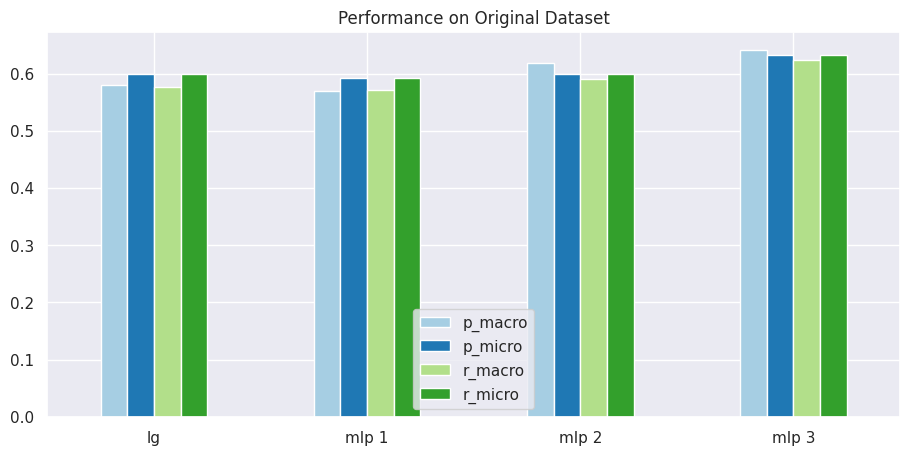

In [25]:
# visualize performance of each model on dataset
plot_results_graph(results, title="Performance on Original Dataset")

As you can see above, the **MLP classifier** models with custom parameters **performs better in all metrics** than the models with default parameters.

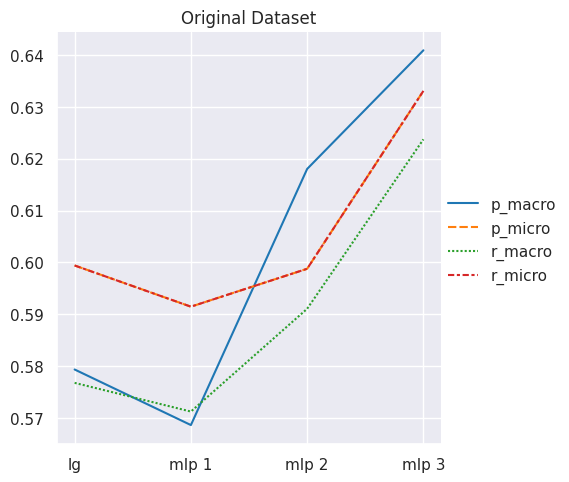

In [26]:
# plot lineplot to see performance trajectory
results_lineplot(results, 'Original Dataset')

#### Observations

From above results and visualizations, it is clear that almost **all metrics improve** as we customize our MLP classifier model with more optimal hyper-parameters.

Initially, Logistic Regression performs better than MLP classifier, which is likely because our MLP classifier only contained a single hidden layer with a 100 neurons. Such a network is not well capable of fitting to non-linear and diverse data, such as textual data, that well.

MLP Classifier with greater number of layers and more neurons is better able to fit itself to the processed textual data and hence yields better results.

You may also notice that macro-averaging based precision and recall scores are slightly lower than the micro-averaging based precision and recall score. This is common in multi-class classification problem. We will discuss this later in detail.

### Comparison 2 - Derived Dataset 1

In [27]:
# obtain mean score results for Derived Dataset 1
results = get_dataset_mean_scores(d1_ds_idx)
results

,p_macro,p_micro,r_macro,r_micro
lg,0.643936,0.667669,0.647802,0.667669
mlp 1,0.592780,0.609104,0.594034,0.609104
mlp 2,0.624089,0.619103,0.609622,0.619103
mlp 3,0.655973,0.670366,0.655453,0.670366


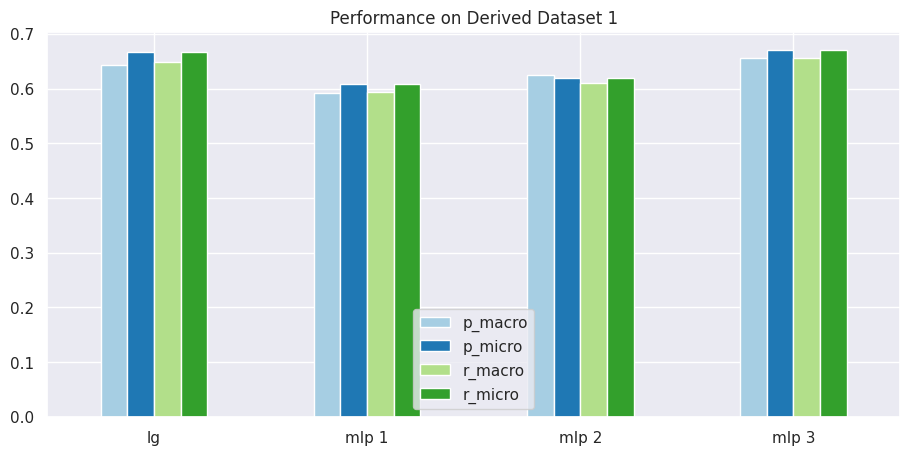

In [28]:
# visualize performance of each model on dataset
plot_results_graph(results, title="Performance on Derived Dataset 1")

As you can observe from above, MLP Classifier fails to gain subtantial edge over Logistic Regression, implying that in this case, we didn't really obtain any additional benefit from deep learning compared to supervised learning.

If we are using the **balanced dataset**, you may also notice that macro and micro averages are quite similar, this is because of the low level of class imbalance in the dataset.

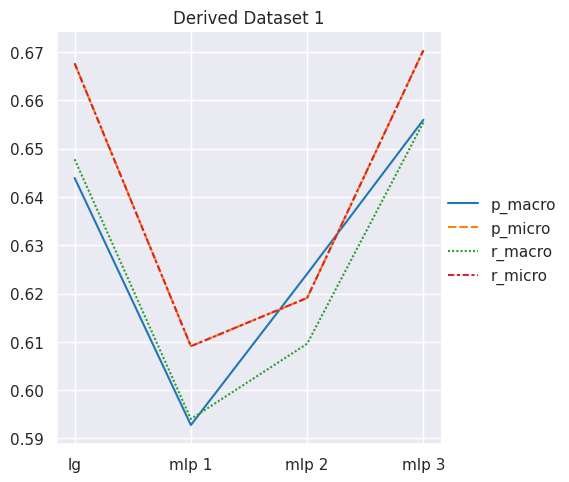

In [29]:
# plot lineplot to see performance trajectory
results_lineplot(results, 'Derived Dataset 1')

#### Observations

From above we can deduce that our deep learning model - MLP Classifier - fails to outperform our supervised learning based Logistic Regression model.

**Why?**

One reason why the supervised learning model may be performing quite well is because of the availability of large amounts of annotated data. We have over 6,000 labelled samples available to train our logistic regression model.

On the other hand, our MLP Classifier may be failing to perform well because of the lack of optimal hyper-parameter values. Hyper-parameter tuning in a case like this where the corpus size is substantially large is a compute and time intensive process.

### Comparison 3 - Derived Dataset 2

In [30]:
# obtain mean score results for Derived Dataset 2
results = get_dataset_mean_scores(d2_ds_idx)
results

,p_macro,p_micro,r_macro,r_micro
lg,0.577579,0.595932,0.574841,0.595932
mlp 1,0.559019,0.570690,0.553418,0.570690
mlp 2,0.614525,0.594661,0.587816,0.594661
mlp 3,0.634407,0.632118,0.619935,0.632118


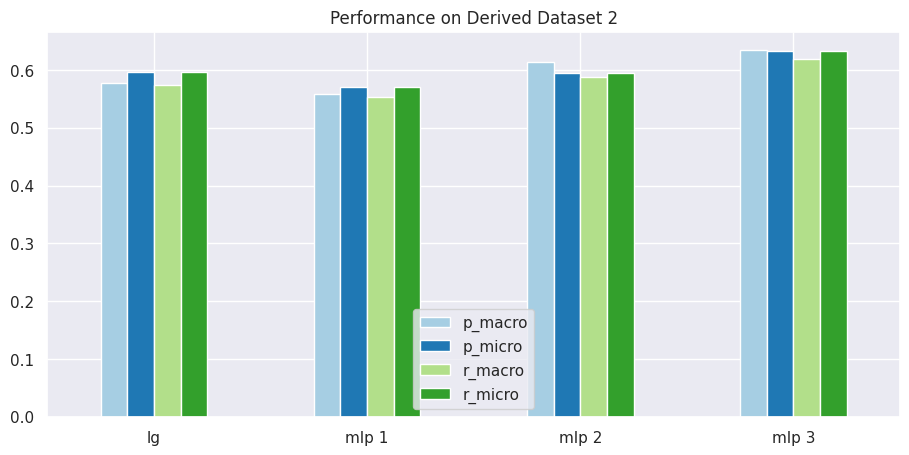

In [31]:
# visualize performance of each model on dataset
plot_results_graph(results, title="Performance on Derived Dataset 2")

From above you can notice that our logistic regression model and the first two variants of MLP classifier perform worse on the derived dataset 2, whereas, the MLP 3 variant is able to perform slightly better than other models. However, in general, all models perform less better with **derived dataset 2** than with the **derived dataset 1**.

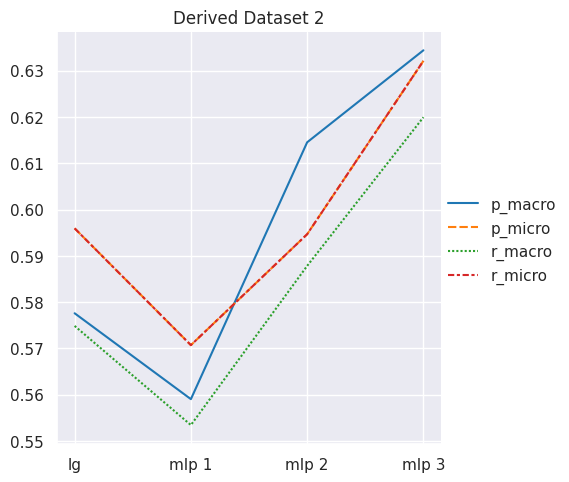

In [32]:
# plot lineplot to see performance trajectory
results_lineplot(results, 'Derived Dataset 2')

#### Observations

We get lower performance results from models with **derived dataset 2**, however we can notice that our MLP classifier model (variant 3) is able to perform better results than the supervised logistic regression model when training using this dataset.

One reason for MLP 3 performing better maybe the use of **SGD** optimizer, since it enables the model to generalize better, and our **derived dataset 2** has larger set of features than the **derived dataset 1** which only contains POS tags and not the NE tags.

### Comparison 4 - Precision and Recall

Now, let's compare the difference between micro and macro averaging based precision and recall scores for each dataset.

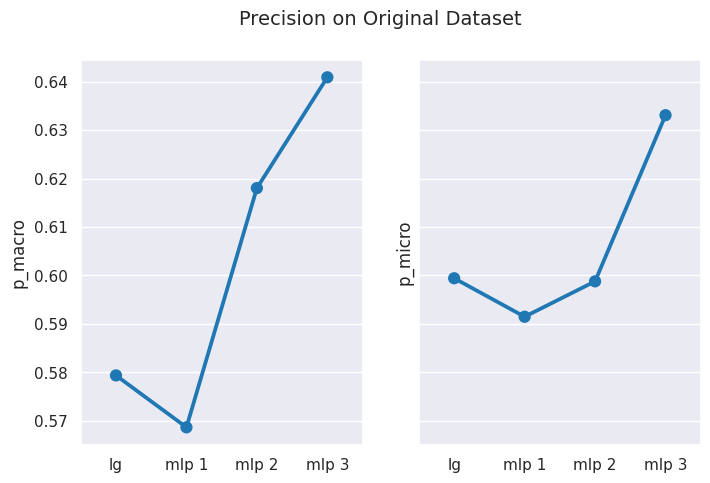

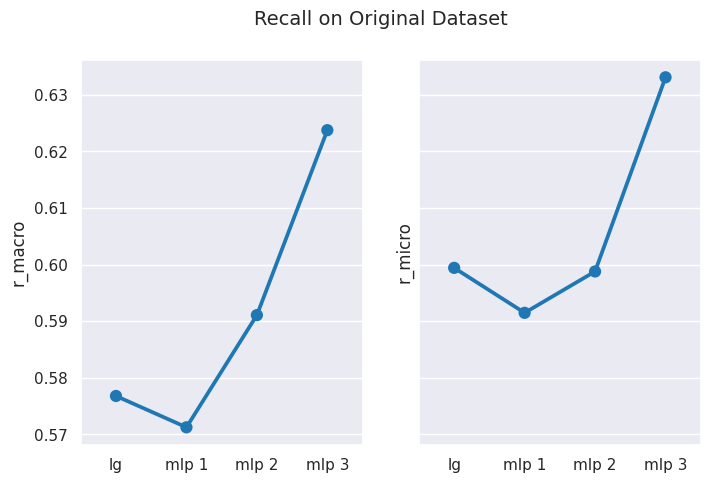

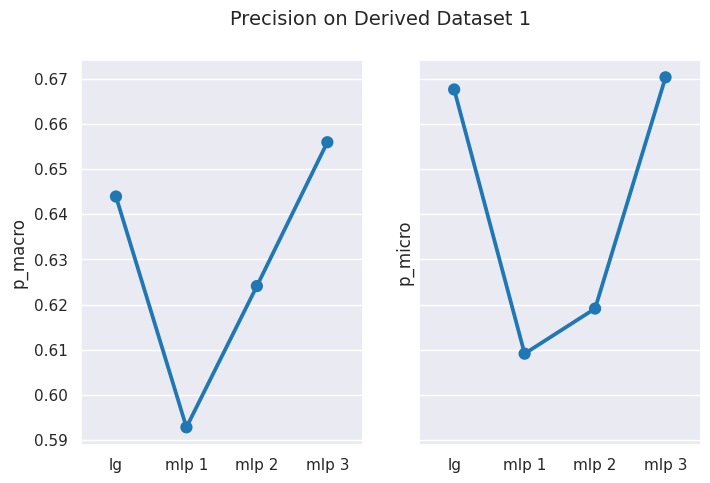

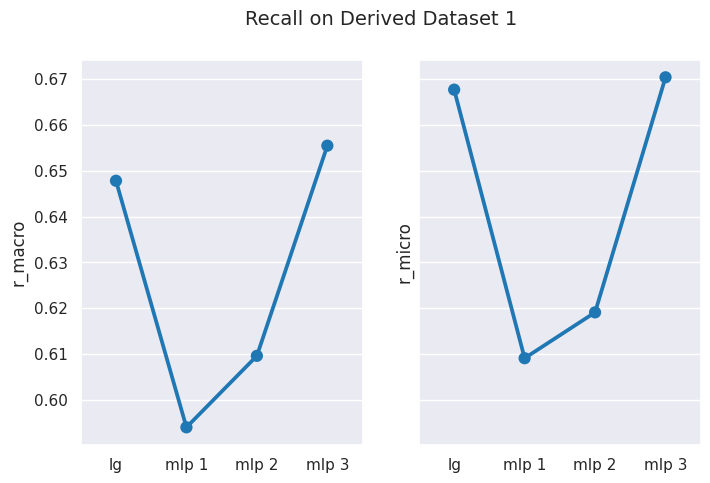

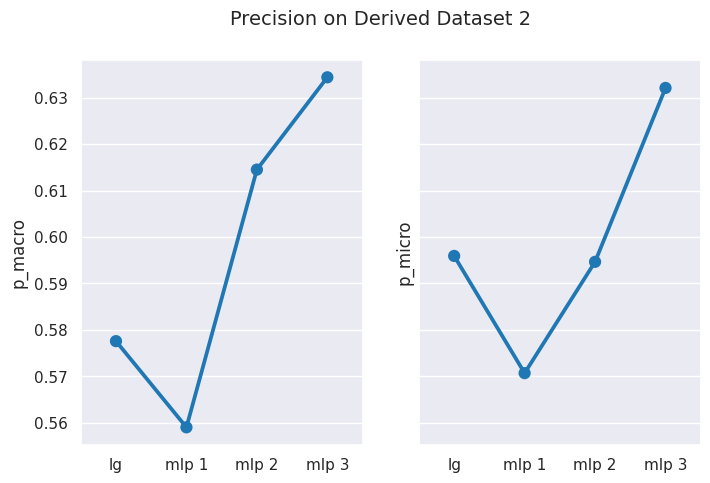

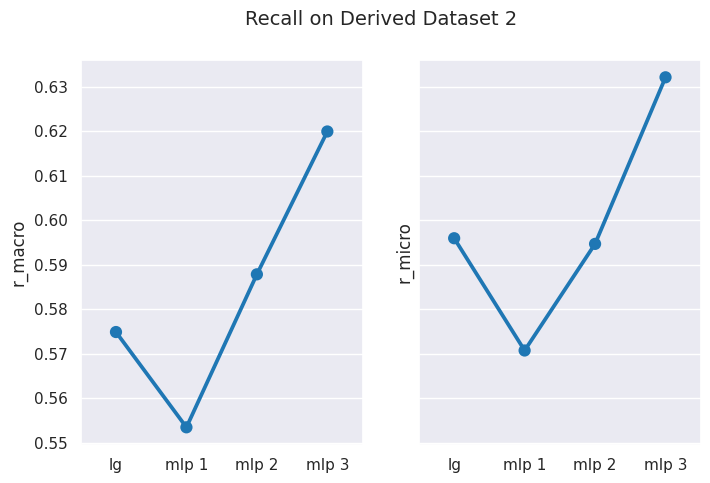

In [33]:
# update theme for clearer visualization
sns.set_theme(style="darkgrid", palette="tab10")

# method to plot graph for metric
def plot_metric_result(results, metric_1, metric_2, title):
  fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 5))
  sns.pointplot(data=results, x=results.index, y=metric_1, ax=ax1)
  sns.pointplot(data=results, x=results.index, y=metric_2, ax=ax2)
  fig.suptitle(title, fontsize=14)
  plt.show()

# Original Dataset
results = get_dataset_mean_scores(org_ds_idx)
plot_metric_result(results, 'p_macro', 'p_micro', 'Precision on Original Dataset')
plot_metric_result(results, 'r_macro', 'r_micro', 'Recall on Original Dataset')

# Derived Dataset 1
results = get_dataset_mean_scores(d1_ds_idx)
plot_metric_result(results, 'p_macro', 'p_micro', 'Precision on Derived Dataset 1')
plot_metric_result(results, 'r_macro', 'r_micro', 'Recall on Derived Dataset 1')

# Derived Dataset 2
results = get_dataset_mean_scores(d2_ds_idx)
plot_metric_result(results, 'p_macro', 'p_micro', 'Precision on Derived Dataset 2')
plot_metric_result(results, 'r_macro', 'r_micro', 'Recall on Derived Dataset 2')

#### Observations

You can clearly observe that scores using macro-averaging are usually lower than those measured using micro-averaging.

**Why?**

In a multiclass classification setting, the **macro-average** precision and recall scores are lower than the **micro-average** ones. This is because the false negatives of some classes are higher than that of other classes due to class imbalance. Therefore, the macro-average metric is more sensitive to the performance of the minority classes, while the micro-average metric is more sensitive to the performance of the majority classes. <sup>[7](#7-sklearn-micro-macro)</sup>

## Summary

In this project:

- We examined the Airline Passengers Review dataset and took necessary steps to handle target class imbalance
- We used [spaCy](https://spacy.io/) for tokenization, lemmatization, POS tagging and Named Entity Recognition
- We generated two additional datasets to train models on, so there datasets available for training were:
  - Original Dataset
  - Derived Dataset 1 - containing wanted POS
  - Derived Dataset 2 - containing wanted POS and NE
- We trained two models, one **supervised learning** based [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model and a **deep learning** based [MLP classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), on our three datasets, using **default parameters**
- We tweaked hyper-parameters of our MLP classifier to obtain **two new variants** of MLP classifier, and trained these models on all three datasets
- Finally, we performed a detailed comparative analysis of the results obtained from our model train, testing and evaluation


In conclusion, though our MLP classifier neural network performed fairly well, the availability of large amounts of labelled data ensured that our supervised learning based Logistic Regression model didn't fall behind on precision or recall metrics. However, if better and more efficient ways of catering to the empirical part of finding optimal hyper-parameters for the neural network based model can be found, then it may yield better results and accuracy.


## References

### 1. Airline Passenger Reviews Dataset

Original: https://www.kaggle.com/datasets/malharkhatu/airline-passenger-reviews

Reduced original: https://github.com/baharin/CSI4106-Assignment4-Datasets/blob/main/reduced_file_AirPassengerReviews.csv

Reduced used in this assignment: https://github.com/pranav-kural/deep-learning-textual-analysis/blob/main/reduced_file_AirPassengerReviews.csv


### 2. Word Classes and Part-of-Speech Tagging in NLP

URL: https://www.scaler.com/topics/nlp/word-classes-and-part-of-speech-tagging-in-nlp/

### 3. Interjections - Universal Dependencies

URL: https://universaldependencies.org/u/pos/INTJ.html

### 4. TF-IDF and Simple Document Search

Video URL: https://youtu.be/fIYSi41f1yg?si=-oFATPFxyop7RnmE


### 5. MLP Classifier

URL: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### 6. Using SGD Optimizer

https://towardsai.net/p/l/why-should-adam-optimizer-not-be-the-default-learning-algorith

### 7. sklearn Micro Macro

https://sklearn-evaluation.ploomber.io/en/latest/classification/micro_macro.html